## 10. 확률론에 입각한 시계열 데이터 분석

### 10.1. STL(Season-Trend decomposition using Loess)을 이용한 요인 분해

STL은 국소회귀(특정 데이터 주변에서 소수의 데이터만 추출하여 평활화 방식으로 회귀계수를 추출하는 방법)를 이용하여 추세, 계절 요인과 잔차를 추출하는 분석 방법입니다.  
순환 요인은 별도로 분해되지 않고 추세 요인에 결합되어 추출됩니다. 

In [2]:
# 준비작업
## 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
from lesson3 import setup_korean_font
setup_korean_font()

# 시계열 분석 관련 라이브러리
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller #, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 랜덤 시드 설정
np.random.seed(42)

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
## 데이터셋 로딩 : flights 데이터셋
flights = sns.load_dataset('flights')

# 데이터 확인
print("데이터 형태:", flights.shape)
print(flights.head(10))

데이터 형태: (144, 3)
   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121
5  1949   Jun         135
6  1949   Jul         148
7  1949   Aug         148
8  1949   Sep         136
9  1949   Oct         119


In [4]:
## 데이터 전처리 : 시계열 데이터로 변환
### 시계열 데이터는 (타임스탬프, 데이터)의 구조를 가져야 합니다. 이를 위해 데이터 프레임 형태의 데이터를 변환하여 타임스탬프를 생성합니다.

#### 월 축약형을 숫자로 매핑
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

#### 각 행별로 날짜 생성
flights['date'] = flights.apply(
    lambda row: pd.Timestamp(year=int(row['year']), 
                             month=month_map[row['month']], 
                             day=1), 
    axis=1
)

#### 시계열 데이터 생성 및 확인
ts_data = flights.set_index('date')['passengers']
ts_data = ts_data.sort_index()

print(ts_data.head(12))
print(f"\n데이터 기간: {ts_data.index[0]} ~ {ts_data.index[-1]}")
print(f"데이터 포인트 수: {len(ts_data)}")

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: passengers, dtype: int64

데이터 기간: 1949-01-01 00:00:00 ~ 1960-12-01 00:00:00
데이터 포인트 수: 144


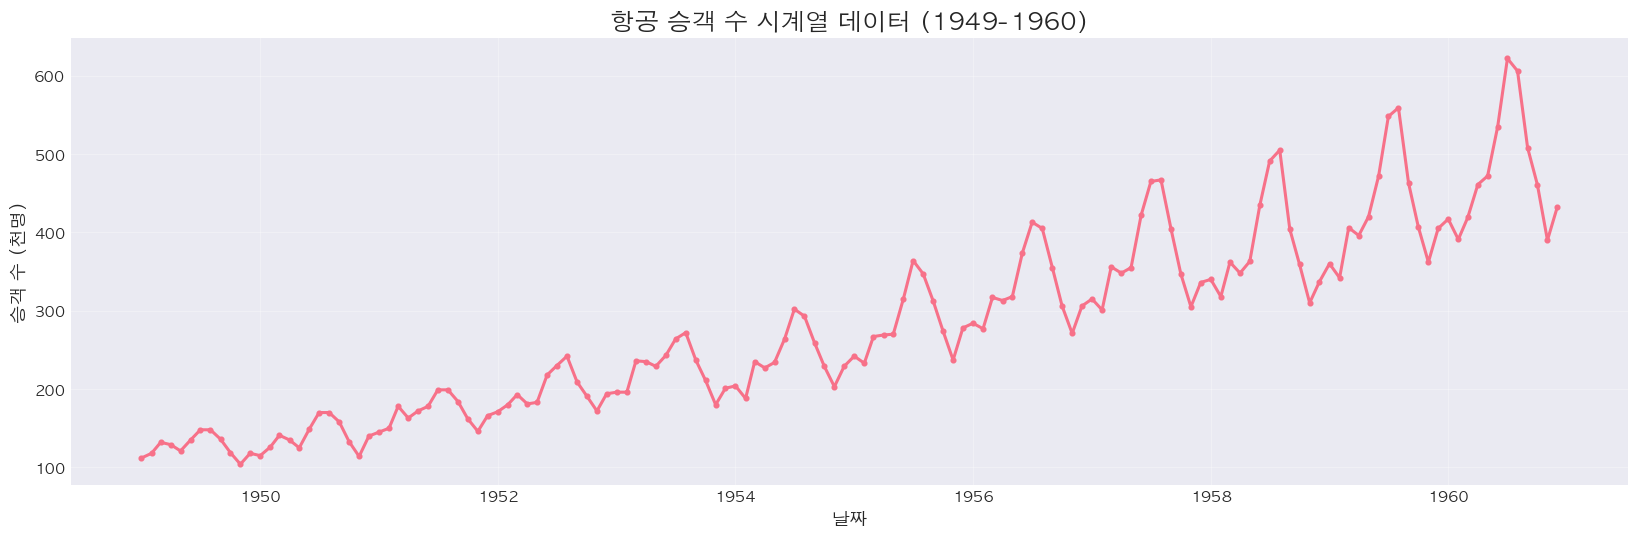

In [5]:
# EDA : 시계열 데이터 시각화
## 한글 폰트 재설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 5))
plt.plot(ts_data, linewidth=2, marker='o', markersize=3)
plt.title('항공 승객 수 시계열 데이터 (1949-1960)', fontsize=16, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('승객 수 (천명)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# 분석 수행 : STL 분해
stl = STL(ts_data, seasonal=13, trend=None, period=12)
result = stl.fit()

# 분해 결과 확인
print(f"원본 데이터 평균: {ts_data.mean():.2f}")
print(f"추세 성분 평균: {result.trend.mean():.2f}")
print(f"계절 성분 평균: {result.seasonal.mean():.2f}")
print(f"잔차 성분 평균: {result.resid.mean():.2f}")

원본 데이터 평균: 280.30
추세 성분 평균: 280.24
계절 성분 평균: 0.18
잔차 성분 평균: -0.12


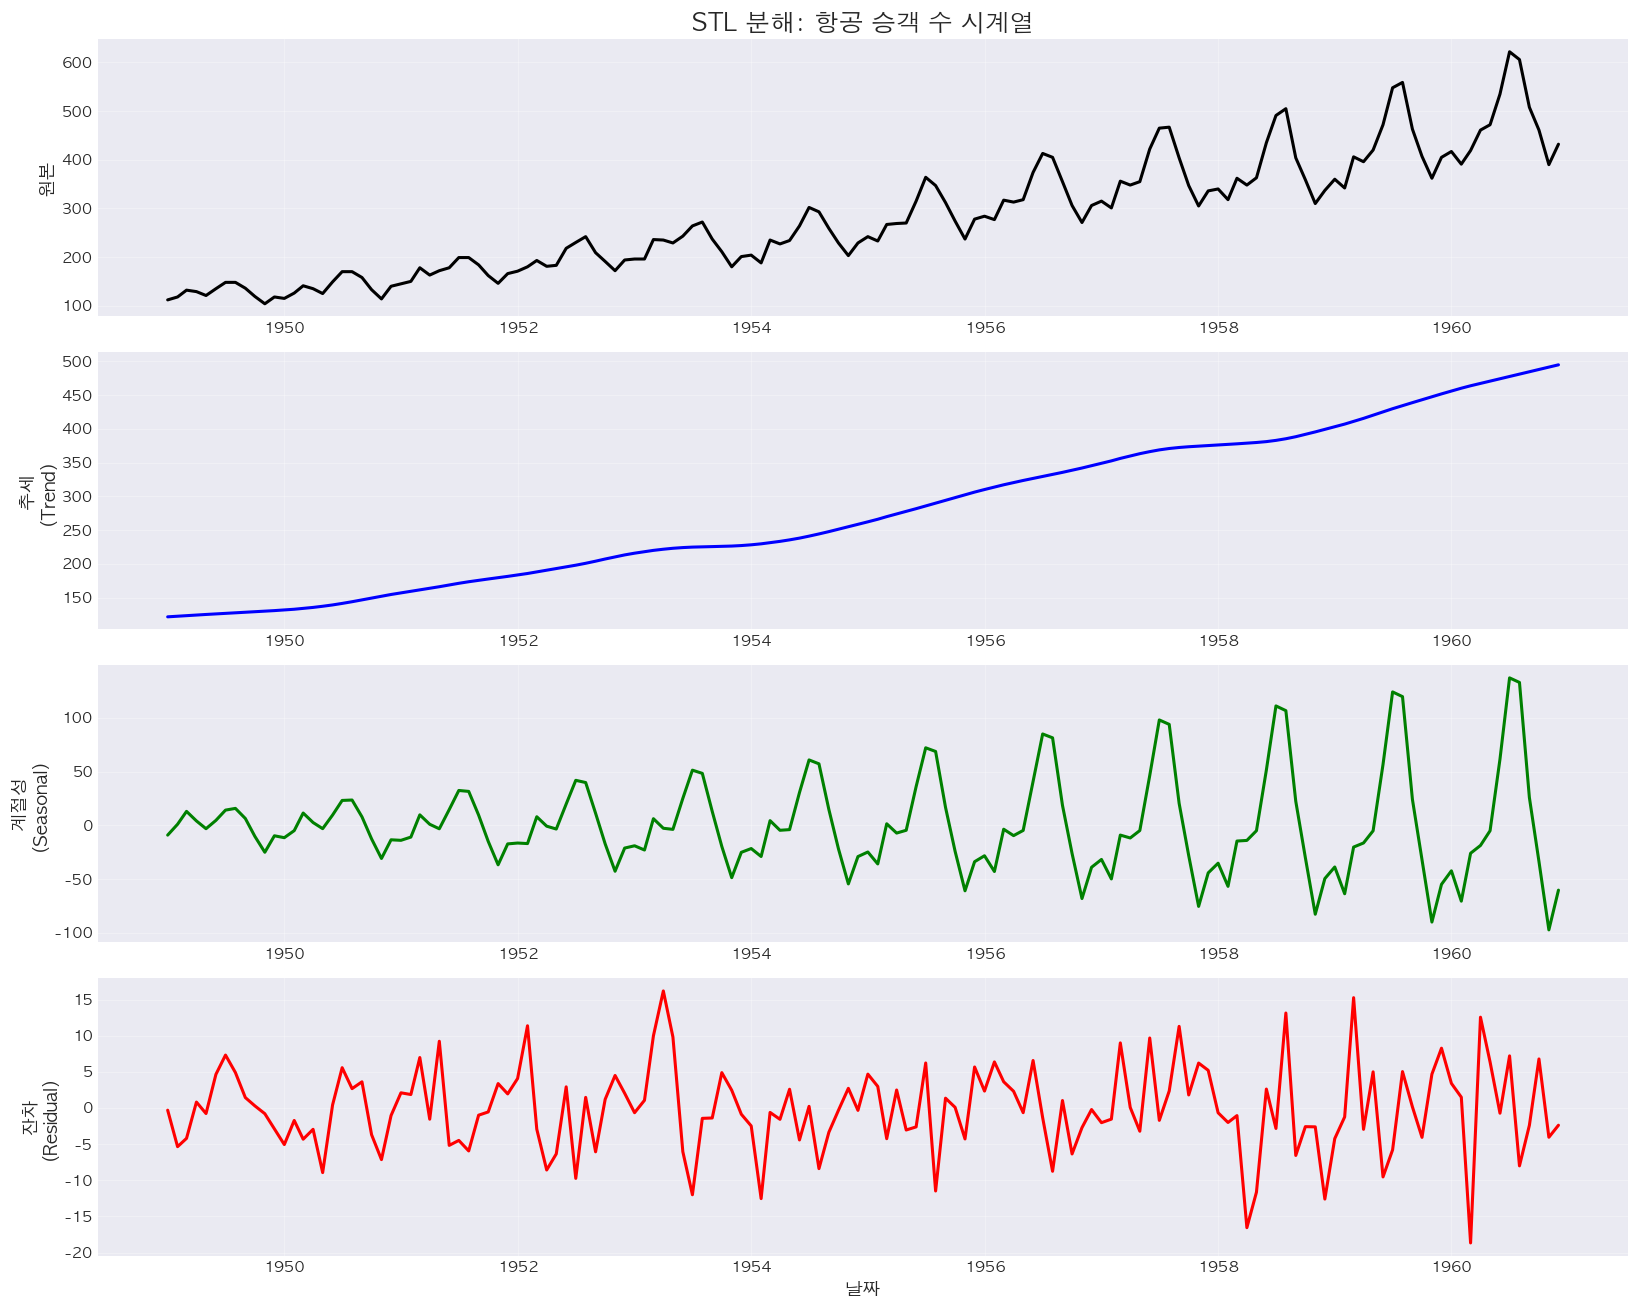

In [7]:
## STL 분해 결과 시각화
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# 원본
axes[0].plot(ts_data, linewidth=2, color='black')
axes[0].set_ylabel('원본', fontsize=12, fontweight='bold')
axes[0].set_title('STL 분해: 항공 승객 수 시계열', fontsize=16, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 추세 성분
axes[1].plot(result.trend, linewidth=2, color='blue')
axes[1].set_ylabel('추세\n(Trend)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 계절 성분
axes[2].plot(result.seasonal, linewidth=2, color='green')
axes[2].set_ylabel('계절성\n(Seasonal)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# 잔차 성분
axes[3].plot(result.resid, linewidth=2, color='red')
axes[3].set_ylabel('잔차\n(Residual)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('날짜', fontsize=12)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 10.2. ARIMA 모형 적합

STL을 이용하여 분해한 잔차 성분에 ARIMA 모형을 적합하고, 모형을 이용하여 테스트 데이터를 예측하겠습니다. (올바른 분석 순서의 예시입니다.)

데이터 포인트 수: 144
평균: -0.1212
표준편차: 5.9628
최소값: -18.67
최대값: 16.19


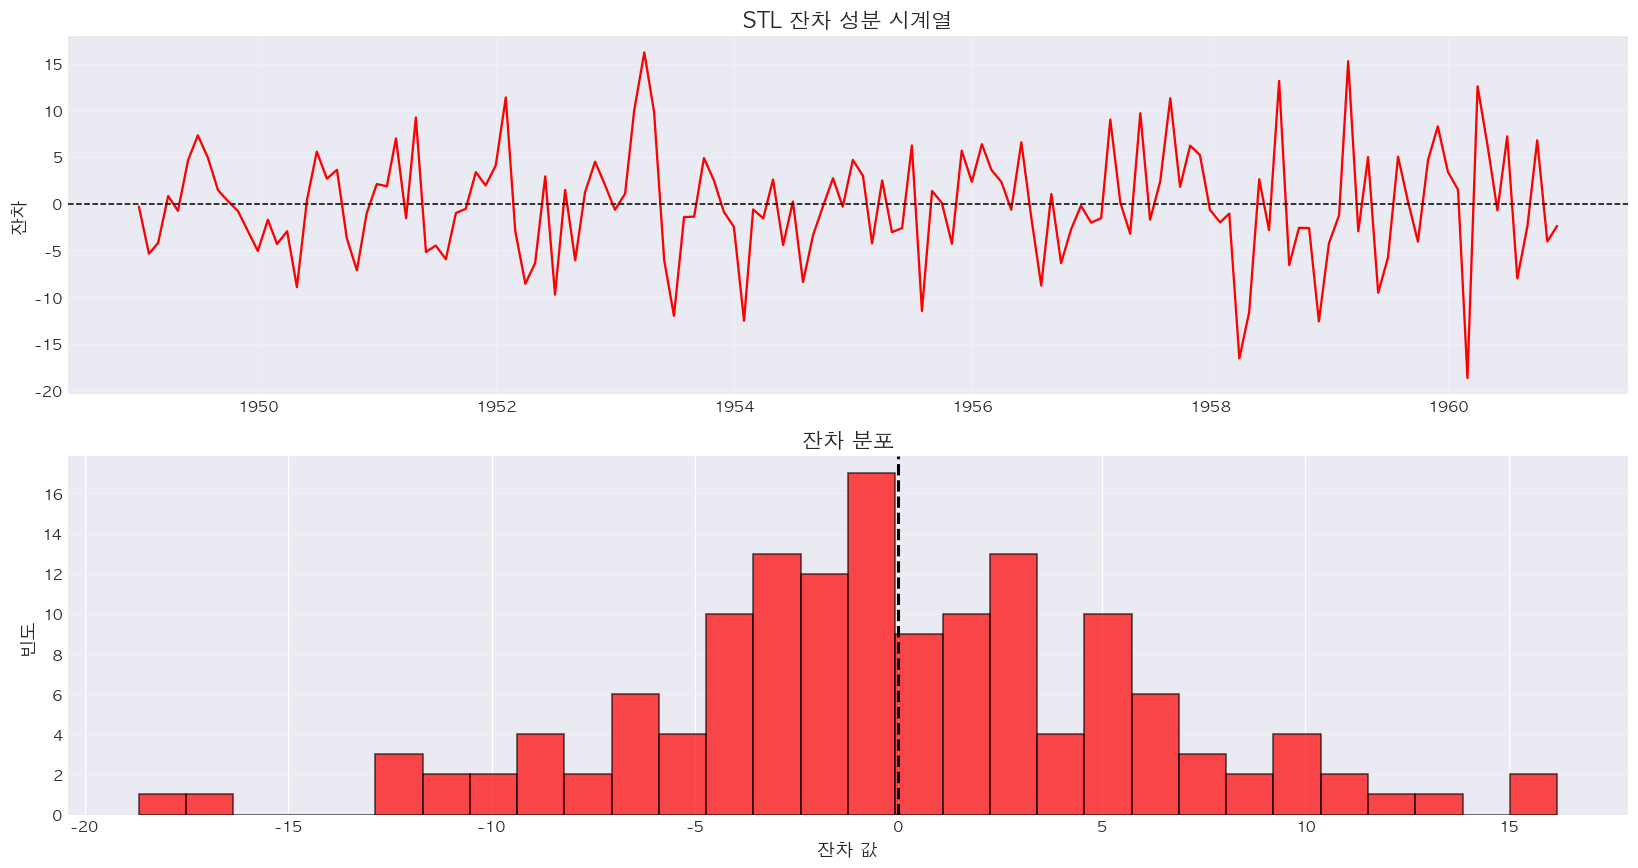

In [8]:
# 데이터 준비 : STL 객체로부터 잔차 성분 추출
resid_data = result.resid.dropna()

## EDA
### 요약통계량
print(f"데이터 포인트 수: {len(resid_data)}")
print(f"평균: {resid_data.mean():.4f}")
print(f"표준편차: {resid_data.std():.4f}")
print(f"최소값: {resid_data.min():.2f}")
print(f"최대값: {resid_data.max():.2f}")

### 잔차 성분 시각화
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

### 잔차 시계열 플롯
axes[0].plot(resid_data, linewidth=1.5, color='red')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('STL 잔차 성분 시계열', fontsize=14, fontweight='bold')
axes[0].set_ylabel('잔차', fontsize=12)
axes[0].grid(True, alpha=0.3)

### 잔차 히스토그램
axes[1].hist(resid_data, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1].set_title('잔차 분포', fontsize=14, fontweight='bold')
axes[1].set_xlabel('잔차 값', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [9]:
# 잔차 데이터의 정상성 검정 : 디키-풀러 검정
def adf_test(timeseries, name=''):
    """
    ADF 검정을 수행하고 결과를 출력하는 함수
    
    귀무가설(H0): 시계열이 단위근을 가짐 (비정상성)
    대립가설(H1): 시계열이 정상성을 가짐
    """
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'ADF 통계량: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'사용된 시차(Lags): {result[2]}')
    print(f'관측치 수: {result[3]}')
    print('\n임계값:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"\n✅ 결론: p-value({result[1]:.6f}) <= 0.05")
        print("   귀무가설 기각 → 시계열은 정상성을 가집니다.")
    else:
        print(f"\n❌ 결론: p-value({result[1]:.6f}) > 0.05")
        print("   귀무가설 채택 → 시계열은 비정상성을 가집니다.")
        print("   → 차분(differencing)이 필요합니다.")

# 잔차 데이터의 정상성 검정
adf_test(resid_data, 'STL 잔차 성분')

ADF 통계량: -5.098011
p-value: 0.000014
사용된 시차(Lags): 9
관측치 수: 134

임계값:
  1%: -3.480
  5%: -2.883
  10%: -2.578

✅ 결론: p-value(0.000014) <= 0.05
   귀무가설 기각 → 시계열은 정상성을 가집니다.


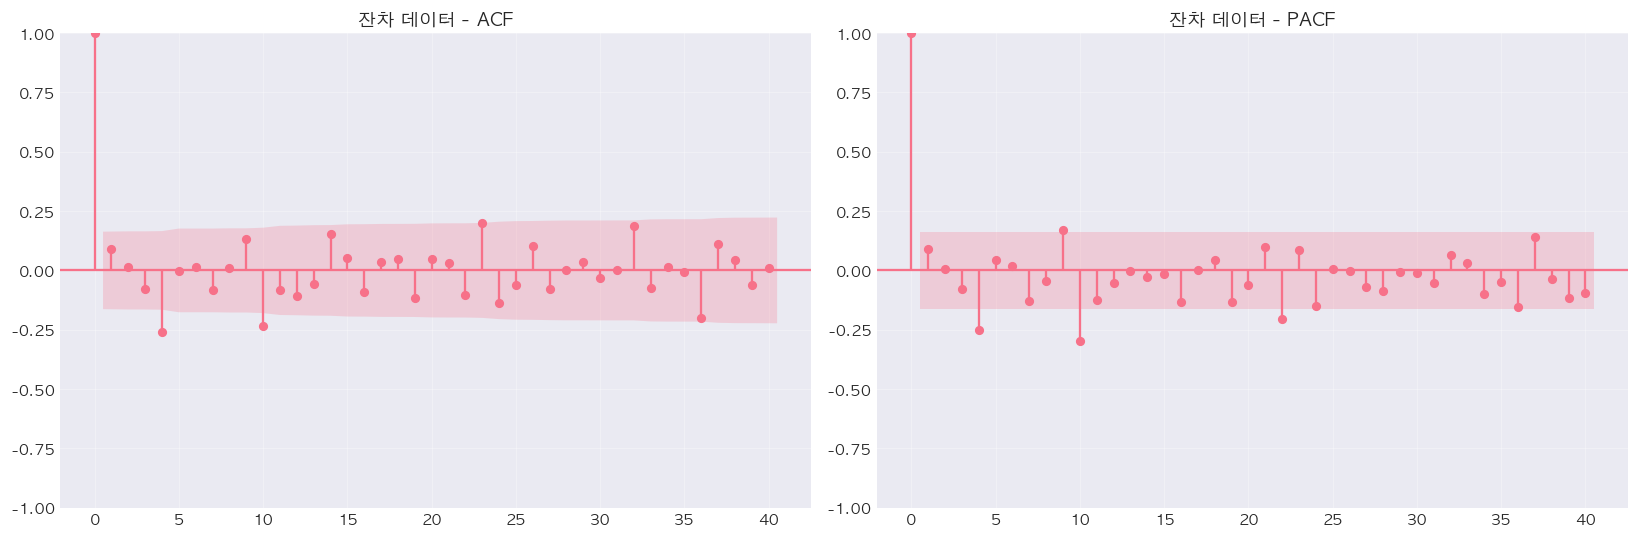

In [10]:
# ACF 및 PACF 플롯을 이용한 ARIMA 차수 결정
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF
plot_acf(resid_data, lags=40, ax=axes[0])
axes[0].set_title('잔차 데이터 - ACF', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(resid_data, lags=40, ax=axes[1])
axes[1].set_title('잔차 데이터 - PACF', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# 훈련/테스트 분할
train_size = int(len(resid_data) * 0.8)
train_resid = resid_data.iloc[:train_size].copy()
test_resid = resid_data.iloc[train_size:].copy()

print(f"전체 잔차 데이터: {len(resid_data)}개")
print(f"훈련 데이터: {len(train_resid)}개 ({train_resid.index[0]} ~ {train_resid.index[-1]})")
print(f"테스트 데이터: {len(test_resid)}개 ({test_resid.index[0]} ~ {test_resid.index[-1]})")

전체 잔차 데이터: 144개
훈련 데이터: 115개 (1949-01-01 00:00:00 ~ 1958-07-01 00:00:00)
테스트 데이터: 29개 (1958-08-01 00:00:00 ~ 1960-12-01 00:00:00)


In [12]:
# grid-search 방식을 이용한 (p, d, q) 조합 탐색
## STL을 통해 추세와 계절요인을 제거했으므로 d=0으로 고정
from itertools import product

## 탐색할 파라미터 범위 설정
p_range = range(0, 4)
d_range = [0]
q_range = range(0, 4)

aic_results = {}

print("ARIMA 모형 탐색 중 (잔차 데이터)...\n")
print(f"{'p':<5}{'d':<5}{'q':<5}{'AIC':<15}{'BIC':<15}")
print("="*50)

for p, d, q in product(p_range, d_range, q_range):
    if p == 0 and q == 0:  # (0,0,0)은 의미 없음
        continue
    try:
        model = ARIMA(train_resid, order=(p, d, q))
        fitted_model = model.fit()
        aic = fitted_model.aic
        bic = fitted_model.bic
        aic_results[(p, d, q)] = {'aic': aic, 'bic': bic, 'model': fitted_model}
        print(f"{p:<5}{d:<5}{q:<5}{aic:<15.2f}{bic:<15.2f}")
    except:
        continue

## 최적 모형 선택 (AIC 기준)
best_order = min(aic_results, key=lambda x: aic_results[x]['aic'])
best_model = aic_results[best_order]['model']

print(f"✅ 최적 모형: ARIMA{best_order}")
print(f"   AIC: {aic_results[best_order]['aic']:.2f}")
print(f"   BIC: {aic_results[best_order]['bic']:.2f}")

ARIMA 모형 탐색 중 (잔차 데이터)...

p    d    q    AIC            BIC            
0    0    1    716.09         724.33         
0    0    2    717.57         728.55         
0    0    3    718.74         732.47         
1    0    0    715.61         723.84         
1    0    1    717.58         728.56         
1    0    2    719.43         733.15         
1    0    3    718.63         735.10         
2    0    0    717.57         728.55         
2    0    1    719.56         733.29         
2    0    2    718.65         735.12         
2    0    3    710.93         730.15         
3    0    0    719.33         733.06         
3    0    1    709.53         726.00         
3    0    2    711.24         730.45         
3    0    3    720.14         742.10         
✅ 최적 모형: ARIMA(3, 0, 1)
   AIC: 709.53
   BIC: 726.00


In [13]:
## 최적 모형 결과 요약
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  115
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -348.764
Date:                Tue, 04 Nov 2025   AIC                            709.528
Time:                        09:33:19   BIC                            725.997
Sample:                    01-01-1949   HQIC                           716.213
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0891      0.116     -0.767      0.443      -0.317       0.139
ar.L1          1.1039      0.112      9.894      0.000       0.885       1.323
ar.L2         -0.1535      0.145     -1.057      0.2

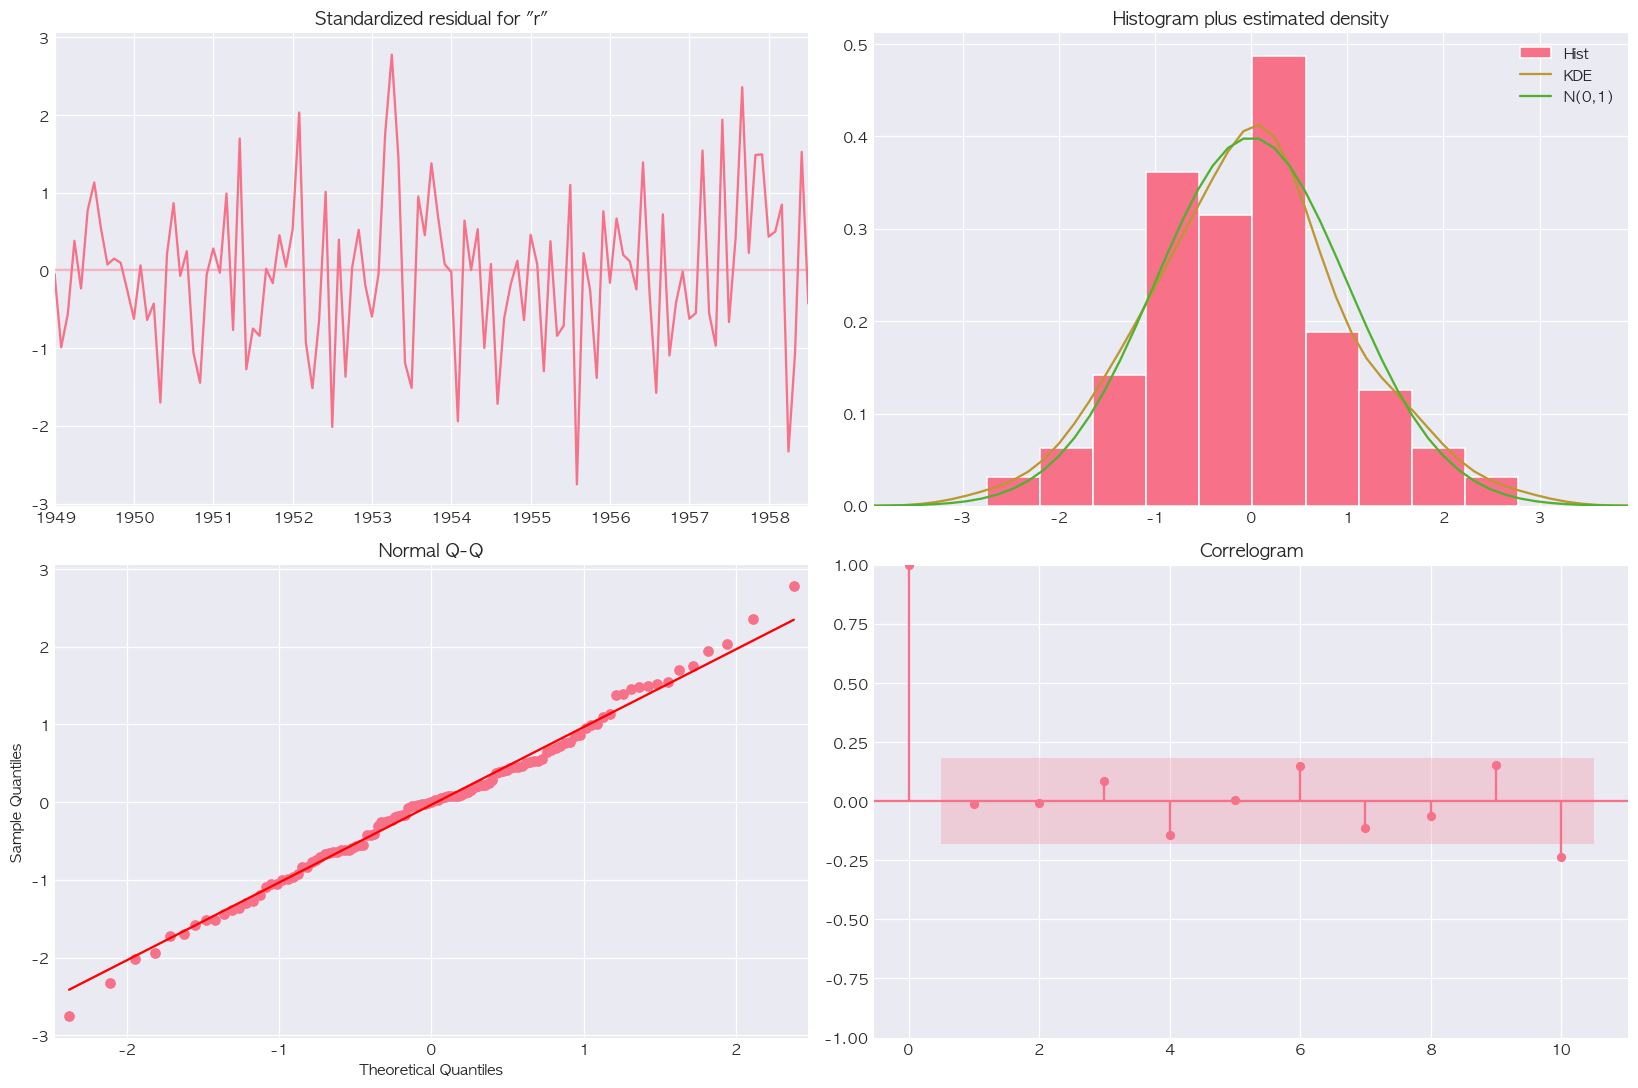

In [14]:
# 잔차 진단
fig = best_model.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

미래 데이터를 예측하기 위해 (1) ARIMA 모형으로 잔차를 예측하고, (2) STL의 추세 + 계절 + 예측 잔차를 결합하여 최종 예측값을 계산합니다.

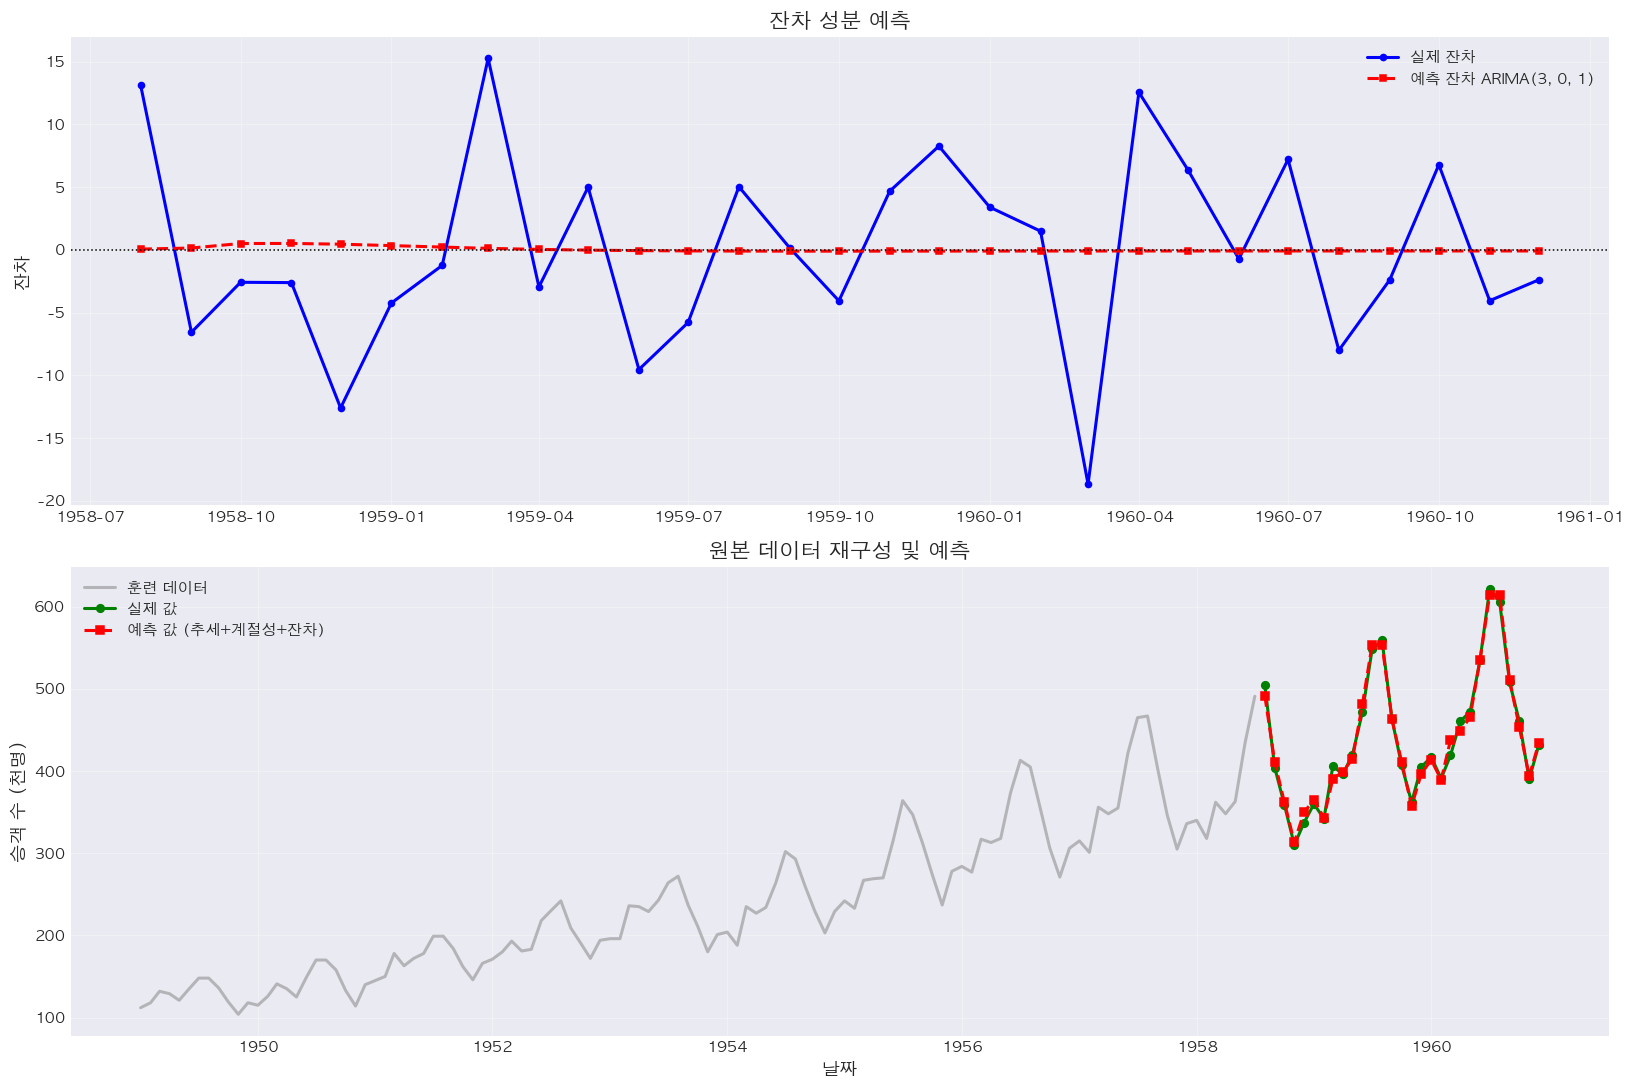

In [15]:
# 잔차 예측
forecast_steps = len(test_resid)
resid_forecast = best_model.forecast(steps=forecast_steps)

# 원본 데이터 재구성을 위한 추세 및 계절성 추출
test_indices = test_resid.index
trend_component = result.trend.loc[test_indices]
seasonal_component = result.seasonal.loc[test_indices]

# 원본 데이터 = 추세 + 계절성 + 잔차
forecast_reconstructed = trend_component + seasonal_component + resid_forecast

# 실제 테스트 데이터 (원본)
test_actual = ts_data.loc[test_indices]

# 예측 결과 시각화
# plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 상단: 잔차 예측
axes[0].plot(test_resid.index, test_resid.values, 
             label='실제 잔차', linewidth=2, color='blue', marker='o', markersize=4)
axes[0].plot(test_resid.index, resid_forecast, 
             label=f'예측 잔차 ARIMA{best_order}', linewidth=2, color='red', 
             linestyle='--', marker='s', markersize=4)
axes[0].axhline(y=0, color='black', linestyle=':', linewidth=1)
axes[0].set_title('잔차 성분 예측', fontsize=14, fontweight='bold')
axes[0].set_ylabel('잔차', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# 하단: 재구성된 원본 데이터 예측
train_actual = ts_data.loc[train_resid.index]
axes[1].plot(train_actual.index, train_actual.values, 
             label='훈련 데이터', linewidth=2, color='gray', alpha=0.5)
axes[1].plot(test_actual.index, test_actual.values, 
             label='실제 값', linewidth=2, color='green', marker='o', markersize=5)
axes[1].plot(test_indices, forecast_reconstructed, 
             label='예측 값 (추세+계절성+잔차)', linewidth=2, color='red', 
             linestyle='--', marker='s', markersize=5)
axes[1].set_title('원본 데이터 재구성 및 예측', fontsize=14, fontweight='bold')
axes[1].set_xlabel('날짜', fontsize=12)
axes[1].set_ylabel('승객 수 (천명)', fontsize=12)
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 10.3. ARIMA 모형만을 이용한 분석

ARIMA의 차분을 이용하여 비정상 요인을 제거하는 방식으로 데이터를 정상화한 후 모형을 적합하는 예시입니다. (잘못된 분석 예시입니다.)

In [16]:
# 원본 데이터로 train/test 분할
train_size_orig = int(len(ts_data) * 0.8)
train_orig = ts_data.iloc[:train_size_orig].copy()
test_orig = ts_data.iloc[train_size_orig:].copy()

print(f"전체 데이터: {len(ts_data)}개")
print(f"훈련 데이터: {len(train_orig)}개 ({train_orig.index[0]} ~ {train_orig.index[-1]})")
print(f"테스트 데이터: {len(test_orig)}개 ({test_orig.index[0]} ~ {test_orig.index[-1]})")

# 원본 데이터의 정상성 검정
adf_test(train_orig, '원본 시계열 데이터')

전체 데이터: 144개
훈련 데이터: 115개 (1949-01-01 00:00:00 ~ 1958-07-01 00:00:00)
테스트 데이터: 29개 (1958-08-01 00:00:00 ~ 1960-12-01 00:00:00)
ADF 통계량: -0.356889
p-value: 0.917052
사용된 시차(Lags): 13
관측치 수: 101

임계값:
  1%: -3.497
  5%: -2.891
  10%: -2.582

❌ 결론: p-value(0.917052) > 0.05
   귀무가설 채택 → 시계열은 비정상성을 가집니다.
   → 차분(differencing)이 필요합니다.


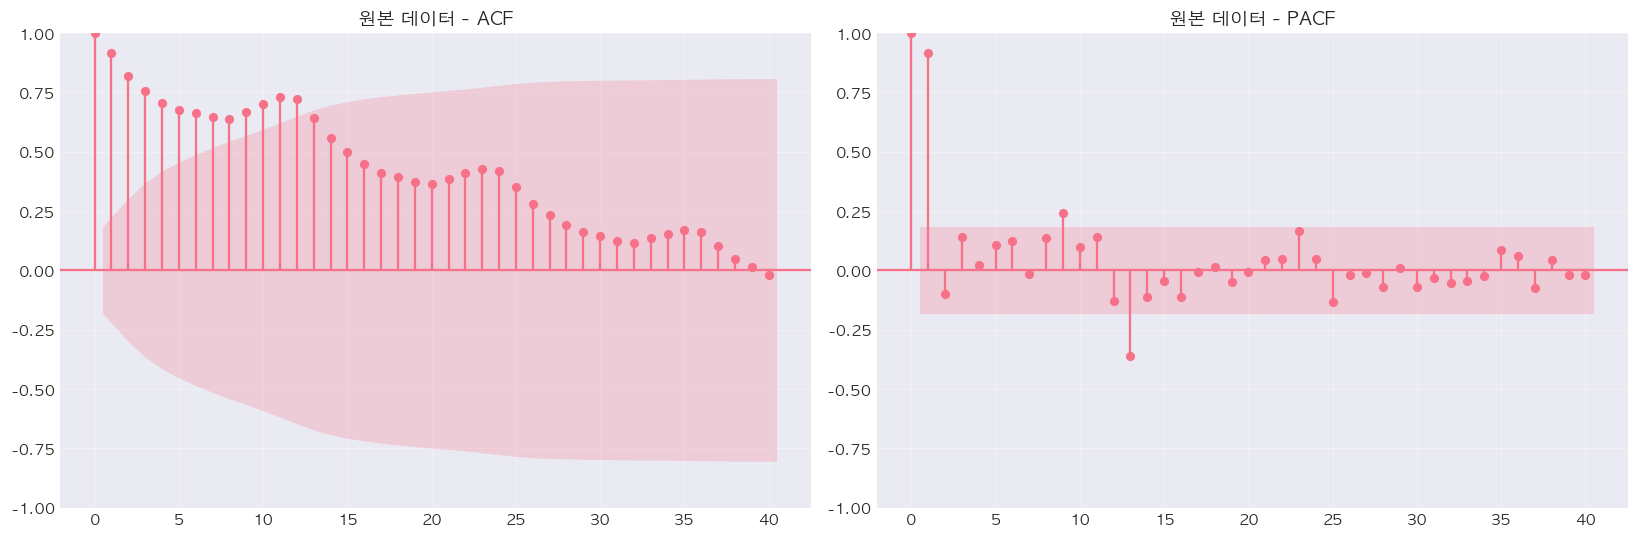

In [17]:
# 원본 데이터의 ACF/PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF
plot_acf(train_orig, lags=40, ax=axes[0])
axes[0].set_title('원본 데이터 - ACF', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(train_orig, lags=40, ax=axes[1])
axes[1].set_title('원본 데이터 - PACF', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# ARIMA 모형 그리드 탐색
p_range_orig = range(0, 3)
d_range_orig = range(0, 3)
q_range_orig = range(0, 3)

aic_results_orig = {}

print("원본 데이터 ARIMA 모형 탐색 중...\n")
print(f"{'p':<5}{'d':<5}{'q':<5}{'AIC':<15}{'BIC':<15}")
print("="*50)

for p, d, q in product(p_range_orig, d_range_orig, q_range_orig):
    if p == 0 and d == 0 and q == 0:
        continue
    try:
        model_orig = ARIMA(train_orig, order=(p, d, q))
        fitted_model_orig = model_orig.fit()
        aic_orig = fitted_model_orig.aic
        bic_orig = fitted_model_orig.bic
        aic_results_orig[(p, d, q)] = {
            'aic': aic_orig, 
            'bic': bic_orig, 
            'model': fitted_model_orig
        }
        print(f"{p:<5}{d:<5}{q:<5}{aic_orig:<15.2f}{bic_orig:<15.2f}")
    except:
        continue

# 최적 모형 선택 (AIC 기준)
best_order_orig = min(aic_results_orig, key=lambda x: aic_results_orig[x]['aic'])
best_model_orig = aic_results_orig[best_order_orig]['model']

print(f"\n{'='*50}")
print(f"✅ 최적 모형: ARIMA{best_order_orig}")
print(f"   AIC: {aic_results_orig[best_order_orig]['aic']:.2f}")
print(f"   BIC: {aic_results_orig[best_order_orig]['bic']:.2f}")

원본 데이터 ARIMA 모형 탐색 중...

p    d    q    AIC            BIC            
0    0    1    1232.92        1241.15        
0    0    2    1178.06        1189.04        
0    1    0    1076.27        1079.01        
0    1    1    1063.65        1069.12        
0    1    2    1060.69        1068.89        
0    2    0    1105.71        1108.44        
0    2    1    1072.85        1078.30        
0    2    2    1060.35        1068.53        
1    0    0    1092.21        1100.45        
1    0    1    1078.07        1089.05        
1    0    2    1076.30        1090.02        
1    1    0    1068.54        1074.01        
1    1    1    1058.25        1066.45        
1    1    2    1057.33        1068.27        
1    2    0    1101.10        1106.55        
1    2    1    1065.18        1073.36        
1    2    2    1054.89        1065.80        
2    0    0    1083.13        1094.11        
2    0    1    1073.81        1087.53        
2    0    2    1074.54        1091.01        
2    1   

In [19]:
# 원본 ARIMA 모형 요약
print(best_model_orig.summary())

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  115
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -523.445
Date:                Tue, 04 Nov 2025   AIC                           1054.889
Time:                        09:33:39   BIC                           1065.799
Sample:                    01-01-1949   HQIC                          1059.316
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5137      0.123     -4.192      0.000      -0.754      -0.274
ma.L1         -0.0843     13.779     -0.006      0.995     -27.090      26.921
ma.L2         -0.9155     12.593     -0.073      0.9

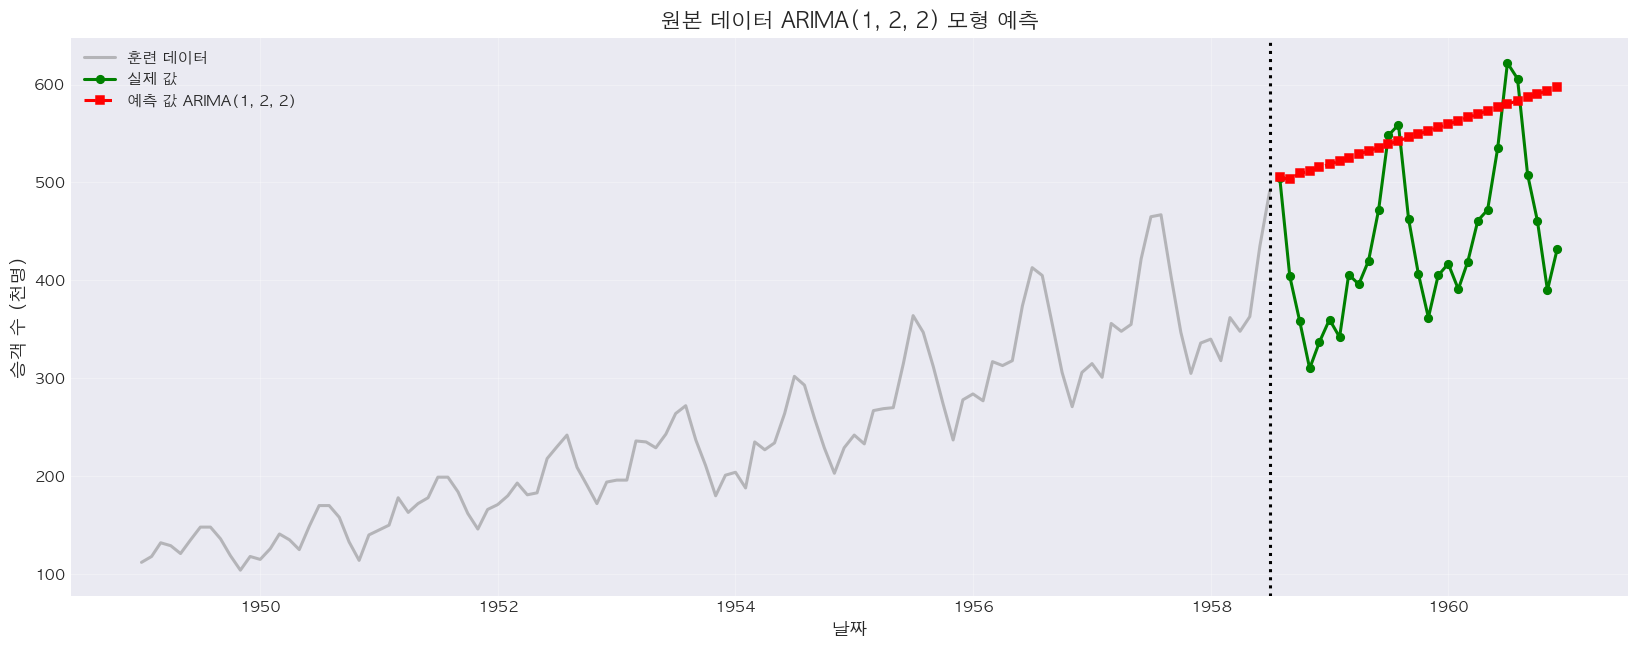

In [20]:
# 원본 데이터 모형 예측
forecast_steps_orig = len(test_orig)
forecast_orig = best_model_orig.forecast(steps=forecast_steps_orig)

# 예측 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(train_orig.index, train_orig.values, 
         label='훈련 데이터', linewidth=2, color='gray', alpha=0.5)
plt.plot(test_orig.index, test_orig.values, 
         label='실제 값', linewidth=2, color='green', marker='o', markersize=5)
plt.plot(test_orig.index, forecast_orig, 
         label=f'예측 값 ARIMA{best_order_orig}', linewidth=2, color='red', 
         linestyle='--', marker='s', markersize=5)
plt.axvline(x=train_orig.index[-1], color='black', linestyle=':', linewidth=2)
plt.title(f'원본 데이터 ARIMA{best_order_orig} 모형 예측', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('승객 수 (천명)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()